--- Kheire --- 

Work in progress. 

Data Cleaning Phase 1 is ready. 

Data Cleaning Phase 2 is work in progress. It is done on the scraped data. 

This Notebook illustrates the different steps taken to do the data cleaning and feature engineering.

In [308]:
# import necessary libraries
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import re
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Cleaning Phase 1

This the first phase of data cleaning. It is very basic and is done on the data format and columns names. 

The first thing noticed was that when reading the original csv file "books.csv" some contents of sepicific sections in specific rows were separated by commas. This caused an error, because pd.read_csv considered them as content belonging to different sections (i.e. columns), resulting in different number of columns for several rows. Luckily, these content were separate by a comma and space ", ", which made it easy to solve the problem by replacing the ", " by "/" as seen below. "books_updated.csv" is the new updated csv which is read by pandas with success.

In [309]:
### COMMENT THE FOLLOWING CELL IF YOU HAVE ALREADY RUN IT BEFORE AND SAVED THE books_updated.csv ###
# Specify the filename
filename = 'books.csv'
updated_filename = "books_updated.csv"

## In some cases in certain fields such us author the authors are separated by ", " 
## to avoid problems when reading the csv directly using pandas and to retain all rows the following steps done

# Open the file and read lines
with open(filename, 'r', encoding='utf-8') as file: # utf-8 encoding to support all languages since there are non-english content
    lines = file.readlines()

# Process the lines to handle unwanted delimiters
cleaned_lines = []
is_firstline = True # used to avoid updating the first line

for line in lines:
    
    if is_firstline: # if it is the first line i.e. Header do not update it
        is_firstline = False
        cleaned_lines.append(line)
        continue
    cleaned_line = line.replace(', ', '/')

    # Append the cleaned line
    cleaned_lines.append(cleaned_line)

# rejoin all the lines to create a new updated csv
with open(updated_filename, 'w', encoding='utf-8') as output_file:
    for cleaned_line in cleaned_lines:
        output_file.write(cleaned_line + '\n')


In [310]:
# Read the cleaned data into a DataFrame
df = pd.read_csv(updated_filename, delimiter = ",", encoding = 'utf-8', index_col=False) 

# Look at the first 5 rows of the DataFrame
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


Looking closer at the column names, we notice that in one of the column '  num_pages' the name starts with space. For ease of use, it is better to remove this unnecessary space.

In [311]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [312]:
# Remove the space before the column num_pages, for ease of use
df.rename(columns={'  num_pages': '  num_pages'.replace(' ', '')}, inplace=True)
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

Examining the column types, it is noticed that some of the columns that are supposed to be numerical types are object types

In [313]:
types_columns=df.dtypes
number_lines,number_columns=df.shape
print(types_columns)

bookID                 object
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                 object
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count     object
publication_date       object
publisher              object
dtype: object


In [314]:
# investigate if their are non-numerical non-date types in supposedly numerical and date columns

# text_reviews_count 
# Filter the DataFrame to get non-numerical values in the specified column
def check_non_numerical_date(columns_list: list, intended_type: str):
    
    if intended_type == "numerical":
        for column in columns_list:
            non_numerical_values = df.loc[~df[column].apply(pd.to_numeric, errors='coerce').notna()]
            print("The non_numerical_values in column {} : ".format(column), non_numerical_values[column])

    elif intended_type == "date":
        for column in columns_list:
            non_numerical_values = df.loc[~df[column].apply(pd.to_datetime, errors='coerce').notna()]
            print("The non_date_values in column {} : ".format(column), non_numerical_values[column])
    
# Display the non-numerical and non_date values of the selected columns
columns = ["isbn", "isbn13", "text_reviews_count"]
check_non_numerical_date(columns, "numerical")
check_non_numerical_date(["publication_date"], "date")

The non_numerical_values in column isbn :  3        043965548X
12       076790818X
16       076790382X
27       097669400X
40       006076273X
            ...    
11090    030727411X
11101    074347788X
11106    057305133X
11110    843221728X
11115    972233168X
Name: isbn, Length: 985, dtype: object
The non_numerical_values in column isbn13 :  1847    en-US
Name: isbn13, dtype: object
The non_numerical_values in column text_reviews_count :  1847    9/1/2003
Name: text_reviews_count, dtype: object
The non_date_values in column publication_date :  1847      MTV Books
8180     11/31/2000
11098     6/31/1982
Name: publication_date, dtype: object


From the above investigation one can notice the following : 
- isbn is not numerical since some of the isbn codes end with X 
- we notice that at index location 1847 the data is shifted to the left
- dates at index locations 8180 and 11098 were not considered as dates since they are wrong. June and November are 31 days, but in reality they are only 30 days.

Also, as seen below there is one empty cell in publisher column, which is on index location 1847.

In [315]:
df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             1
dtype: int64

In [316]:
df["publisher"][df["publisher"].isna()==True]

1847    NaN
Name: publisher, dtype: object

In [317]:
df.iloc[1847]

bookID                6549/ said the shotgun to the head.
title                                       Saul Williams
authors                                              4.22
average_rating                                743470796.0
isbn                                        9780743470797
isbn13                                              en-US
language_code                                         192
num_pages                                            2762
ratings_count                                         214
text_reviews_count                               9/1/2003
publication_date                                MTV Books
publisher                                             NaN
Name: 1847, dtype: object

One can notice that there is a / in the bookID which separates the BookID from the book title. This must be a result from updating automatically the csv files at the beginning. 

Below is the code to fix this unwanted mistake

In [318]:
bookid_title = df["bookID"].iloc[1847].split('/')


# content of the remaining columns
remaining_columns = df[['title', 'authors', 'average_rating', 'isbn', 'isbn13',
                                   'language_code', 'num_pages', 'ratings_count', 
                                   'text_reviews_count', 'publication_date']].iloc[1847]


# rearrange cells content for each column
df.iloc[1847, 2:] = remaining_columns
df["bookID"].iloc[1847]= bookid_title[0]
df["title"].iloc[1847]= bookid_title[1]

C:\Users\cleme\AppData\Local\Temp\ipykernel_18128\3963356864.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bookID"].iloc[1847]= bookid_title[0]
C:\Users\cleme\AppData\Local\Temp\ipykernel_18128\3963356864.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title"].iloc[1847]= bookid_title[1]


In [319]:
# rechek the content 
df.iloc[1847]

bookID                                          6549
title                  said the shotgun to the head.
authors                                Saul Williams
average_rating                                  4.22
isbn                                     743470796.0
isbn13                                 9780743470797
language_code                                  en-US
num_pages                                        192
ratings_count                                   2762
text_reviews_count                               214
publication_date                            9/1/2003
publisher                                  MTV Books
Name: 1847, dtype: object

In [320]:
# Check the types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   bookID              11127 non-null  object
 1   title               11127 non-null  object
 2   authors             11127 non-null  object
 3   average_rating      11127 non-null  object
 4   isbn                11127 non-null  object
 5   isbn13              11127 non-null  object
 6   language_code       11127 non-null  object
 7   num_pages           11127 non-null  object
 8   ratings_count       11127 non-null  int64 
 9   text_reviews_count  11127 non-null  object
 10  publication_date    11127 non-null  object
 11  publisher           11127 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.0+ MB


For some reasons the supposedly numerical columns became objects 
Re-investigate again if they contain non-numerical content

In [321]:
# re-investigate if there is non-numerical content in supposedly numerical columns
columns = ["average_rating", "isbn13", "text_reviews_count", "num_pages", "ratings_count", "text_reviews_count"]
check_non_numerical_date(columns, "numerical")

The non_numerical_values in column average_rating :  Series([], Name: average_rating, dtype: object)
The non_numerical_values in column isbn13 :  Series([], Name: isbn13, dtype: object)
The non_numerical_values in column text_reviews_count :  Series([], Name: text_reviews_count, dtype: object)
The non_numerical_values in column num_pages :  Series([], Name: num_pages, dtype: object)
The non_numerical_values in column ratings_count :  Series([], Name: ratings_count, dtype: int64)
The non_numerical_values in column text_reviews_count :  Series([], Name: text_reviews_count, dtype: object)


They do not contain non-numerical content, so will transform them to numerical

In [322]:
# convert to numerical
def convert_to_numerical(columns_list: list):
    
    for column in columns_list:
        df[column] = df[column].apply(pd.to_numeric)

columns = ["average_rating", "isbn13", "text_reviews_count", "num_pages", "ratings_count", "text_reviews_count"]

convert_to_numerical(columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  object 
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  int64  
 6   language_code       11127 non-null  object 
 7   num_pages           11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 1.0+ MB


In [323]:
# fix the dates by replacing 31 with 30 in June and November
# convert the date column to type pd.datetime
df["publication_date"].iloc[8180] = '11/30/2000'
df["publication_date"].iloc[11098] = '6/30/1982'

C:\Users\cleme\AppData\Local\Temp\ipykernel_18128\3398859105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["publication_date"].iloc[8180] = '11/30/2000'
C:\Users\cleme\AppData\Local\Temp\ipykernel_18128\3398859105.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["publication_date"].iloc[11098] = '6/30/1982'


Resave the DataFrame to avoid repeating the process each time we want to use the df

In [324]:
df.to_csv("books_updated.csv", index_label=False) # index_label = False so that it does not add another index label to the DataFrame

# Data Cleaning Phase 2

This data cleaning is done on the data set after doing webscraping. Through webscraping extra features were extracted which are: 

- first_publish : this is the date a book was first published (this will help distinguish two different books with the same name)
- book_format : this is the format of the book (some books are present in different formats (paperback, Audio CD, hardcover))
- new_publisher: this is because it was noticed that in the original data some books had wrong publishers
- edition_avgRating: this is the actaul average rating of each edition
- added_toShelves: this is the number of users that added a book to shelves

*For more details about the process of scraping, please refer to scraper/scraper.py*

### Read the Data

In [325]:
# read the scraped data
df_scraped = pd.read_csv("scraper/booksRating_extraFeats.csv")

In [326]:
df_scraped.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,first_published,book_format,new_publisher,edition_avgRating,added_toShelves
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,"July 16, 2005",Paperback,Scholastic Inc,4.57,4405980.0
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,"June 21, 2003",Paperback,Scholastic Inc.,4.50,4518536.0
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,"July 2, 1998",Hardcover,NaN,4.05,7469.0
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,"July 8, 1999",Mass Market Paperback,Scholastic Inc.,4.57,5223956.0
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,"October 1, 2003",Paperback,Scholastic,4.72,172736.0


In [327]:
df_scraped.tail()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,first_published,book_format,new_publisher,edition_avgRating,added_toShelves
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,2004-12-21,Da Capo Press,"December 1, 2004",Paperback,Da Capo Press,4.06,552.0
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,1988-12-01,Penguin Books,"June 27, 1987",Paperback,Penguin Books,4.04,4269.0
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,1993-08-01,Penguin Books,"January 1, 1990",Paperback,Penguin Publishing Group,3.98,4686.0
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2007-02-27,Ecco,"January 1, 2007",Hardcover,Ecco,3.75,2948.0
11126,45641,Las aventuras de Tom Sawyer,Mark Twain,3.91,8497646983,9788497646987,spa,272,113,12,2006-05-28,Edimat Libros,"June 1, 1876",Paperback,NaN,3.72,228.0


In [328]:
df_scraped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  int64  
 6   language_code       11127 non-null  object 
 7   num_pages           11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
 12  first_published     11125 non-null  object 
 13  book_format         11126 non-null  object 
 14  new_publisher       8360 non-null   object 
 15  edition_avgRating   11124 non-null  float64
 16  adde

### Fill Missing Data

In the new dataset, there is 2 missing data in the first_published, 1 missing value in the book_format, 3 missing values in the edition_avgRating and added_toShelves. These were values that the scraper failed to get. Since they are very few, they will be filled manually. 

In [329]:
df_scraped[df_scraped[["first_published", "book_format", "edition_avgRating", "added_toShelves"]].isna().any(axis=1)]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,first_published,book_format,new_publisher,edition_avgRating,added_toShelves
2255,8077,Animales No Se Visten Los (Animals Should Def...,Judi Barrett/Ron Barrett,4.11,1595191356,9781595191359,eng,32,0,0,1991-10-30,Live Oak Media,"January 1, 1970",Paperback,Atheneum Books for Young Readers,NaN,NaN
6396,24062,The Deep (Dive Trilogy),Gordon Korman,3.78,0613674839,9780613674836,eng,148,0,0,2003-07-01,Turtleback Books,NaN,NaN,NaN,NaN,NaN
8476,32552,Essential Tales and Poems,Edgar Allan Poe/Benjamin F. Fisher,4.36,1593080646,9781593080648,en-US,688,66382,109,2004-10-25,Barnes Noble Classics,NaN,Paperback,Barnes & Noble Classics,4.36,92622.0
8520,32703,The Diary of Ellen Rimbauer: My Life at Rose Red,Joyce Reardon/Steven Rimbauer/Ridley Pearson,3.67,0786890436,9780786890439,eng,277,7852,352,2001-04-29,Hyperion,"January 1, 2001",Mass Market Paperback,Hyperion,NaN,NaN


In [330]:
df_scraped.loc[2255, ["edition_avgRating", "added_toShelve"]] = [4.11, 5402]
# df_scraped.loc[6396, ["first_published", "book_format", "new_publisher", "edition_avgRating", "added_toShelve"]] ### !!!! Couldn'y find exact book edition online !!!!
df_scraped.loc[8476, ["first_published"]] = ["January 1, 1843"]
df_scraped.loc[8520, ["edition_avgRating", "added_toShelve"]] = [3.7, 15942]

One of the books at index 6396 was not found on good reads even when searching by book ID, isbn and isbn13. Therefore, the edition_avgRating will be the same as the average_rating. added_toShelves will be equal to the mean of the added_toShelves of the other editions of the book; if other editions are not found the added_toShelves will be equal to the mode of the books having same ratings_count and text_reviews_count. The first_published will be the same as the publication_date and the book_format will be the mode of the books of approximately the same size. 

In [331]:
df_scraped[df_scraped['title'] == df_scraped.loc[6396, 'title']]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,first_published,book_format,new_publisher,edition_avgRating,added_toShelves,added_toShelve
6396,24062,The Deep (Dive Trilogy),Gordon Korman,3.78,0613674839,9780613674836,eng,148,0,0,2003-07-01,Turtleback Books,NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
df_scraped.loc[df_scraped['title'].str.contains('dive', case=False)]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,first_published,book_format,new_publisher,edition_avgRating,added_toShelves,added_toShelve
2021,7271,Marine Conservation Biology: The Science of Ma...,Elliott A. Norse/Larry B. Crowder/Michael E. S...,4.59,1559636629,9781559636629,eng,496,16,2,2005-05-09,Island Press,"May 9, 2005",Paperback,Island Press,4.50,175.0,NaN
4458,16059,The Dive From Clausen's Pier,Ann Packer,3.42,0375727132,9780375727139,eng,432,19844,1747,2003-04-08,Vintage,"January 1, 2002",Paperback,Vintage,3.44,34745.0,NaN
4459,16063,The Dive from Clausen's Pier,Ann Packer,3.42,0749933631,9780749933630,eng,368,60,8,2003-03-27,Piatkus,"January 1, 2002",Paperback,NaN,3.15,90.0,NaN
6385,24037,The Deep (Dive #2),Gordon Korman,3.78,0439507235,9780439507233,eng,148,1436,55,2003-07-01,Scholastic,"July 1, 2003",Paperback,Scholastic,3.78,2837.0,NaN
6386,24040,The Discovery (Dive #1),Gordon Korman,3.72,0439507227,9780439507226,eng,141,1858,135,2003-06-01,Apple Paperbacks (Scholastic),"September 1, 2005",Paperback,Scholastic,3.71,3896.0,NaN
6387,24043,New York City's Best Dive Bars: Drinking and D...,Wendy Mitchell/June Kim,3.75,0970312539,9780970312532,eng,160,16,2,2003-07-01,Gamble Guides,"December 1, 2002",Paperback,Gamble Guides,3.71,32.0,NaN
6396,24062,The Deep (Dive Trilogy),Gordon Korman,3.78,0613674839,9780613674836,eng,148,0,0,2003-07-01,Turtleback Books,NaN,NaN,NaN,NaN,NaN,NaN


-- Clemence --

I found the book on GoodReads : https://www.goodreads.com/book/show/24037.The_Deep

As the information on the goodreads page are not exactly the same as the ones in line 6385, I filled the information manually based on the GoddReads page (the title, num_pages and average rating where the same in the database and the link to goodread).

In [333]:
df_scraped.loc[6396, ["ratings_count", "text_reviews_coun", "first_published","book_format","new_publisher","edition_avgRating","added_toShelves"]] = [1659,66,"July 1, 2003","Paperback","Scholastic",3.78,3004]

In [334]:
df_scraped.iloc[6396]

bookID                                  24062
title                 The Deep (Dive Trilogy)
authors                         Gordon Korman
average_rating                           3.78
isbn                               0613674839
isbn13                          9780613674836
language_code                             eng
num_pages                                 148
ratings_count                            1659
text_reviews_count                          0
publication_date                   2003-07-01
publisher                    Turtleback Books
first_published                  July 1, 2003
book_format                         Paperback
new_publisher                      Scholastic
edition_avgRating                        3.78
added_toShelves                        3004.0
added_toShelve                            NaN
text_reviews_coun                        66.0
Name: 6396, dtype: object

For the new_publisher, the scraper failed to get a lot of values, this is because of how the publisher is saved in the html. Due to constraint of time, and since there is already a publisher column in the original dataset. In the cases where there are NaN the old publisher will be put. The new publisher will be taken, only in the cases where the new publisher is different from the old publisher in value.

In [335]:
# Let's create the function for it. This function will only be use when the text format will be editing, 
#in the subtitle "publisher"

def update_publishers(df):
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Check if the new publisher is different from the old publisher
        if pd.notna(row['new_publisher']) and row['new_publisher'] != row['publisher']:
            # Update the publisher with the new publisher value
            df.at[index, 'publisher'] = row['new_publisher']
        else:
            # Use the old publisher if the new publisher is NaN or the same as the old publisher
            df.at[index, 'publisher'] = row['publisher']
    return df

### Set text columns to lower text

When dealing with text data it always safer to have them all in the same case either lower or upper 

In [336]:
def to_lower(df: pd.DataFrame, columns: list):
    """Function to convert text columns to lowercase"""
    for col in columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.lower()
    return df

In [337]:
# get the text columns
text_columns = df_scraped.select_dtypes(include=['object']).columns

# Convert to lowercase
df_scraped = to_lower(df_scraped, text_columns)

In [338]:
df_scraped.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,first_published,book_format,new_publisher,edition_avgRating,added_toShelves,added_toShelve,text_reviews_coun
277,834,harrington on hold 'em: expert strategy for no...,dan harrington/bill robertie,4.16,1880685353,9781880685358,eng,450,1474,30,2005-06-01,two plus two publishing llc,"june 1, 2005",paperback,two plus two publishing llc,4.17,2403.0,NaN,NaN
10341,41885,sense and sensibility,jane austen,4.07,1593081251,9781593081256,eng,325,1278,153,2004-07-25,barnes & noble,"october 30, 1811",paperback,NaN,4.04,3336.0,NaN,NaN
4735,17015,paranoid park,blake nelson,3.63,0670061182,9780670061181,en-us,180,1109,145,2006-09-21,viking books,"september 21, 2006",hardcover,viking juvenile,3.60,2637.0,NaN,NaN
8028,30786,verserade tankar,lennart hellsing/fibben hald,3.00,9177129334,9789177129332,swe,128,1,0,1999-09-01,alfabeta bokförlag,"september 1, 1999",staple bound,alfabeta bokförlag,2.50,10.0,NaN,NaN
7544,28935,intuition,allegra goodman,3.32,0385336101,9780385336109,eng,385,3248,590,2007-03-13,dial press,"january 1, 2006",paperback,dial press trade paperback,3.31,5857.0,NaN,NaN


### Take First Author Name and Create num_contributors Column

We have decided to take only the name of the first author, since usually first authors are the main authors. Another column will be added to indicate the total number of authors/contributors to the book.

In [339]:
# take the first author in the authors column
df_scraped["first_author"] = df_scraped["authors"].apply(lambda x: x.split("/")[0].strip())


In [340]:
df_scraped["first_author"].sample(5)

5585          p.d. james
2728            alex cox
1384      salman rushdie
2178         theo lesieg
10017    janet evanovich
Name: first_author, dtype: object

In [341]:
df_scraped["num_contributors"] = df_scraped["authors"].apply(lambda x: len(x.split("/")))

In [342]:
df_scraped[["authors","num_contributors"]].sample(5)

,authors,num_contributors
9359,gavin baddeley/dani filth,2
1974,richard a. hawley/john irving,2
1255,michael herr,1
5315,dante alighieri/mark musa,2
6092,stephen r. donaldson,1


### Clean Text Columns

Remove punctuation, and extra white spaces from all text columns.

Better clean the text in publisher column, to avoid having same publishers represented differently. 
Example: indexes 5993, 5365 and 9753, W.W. Norton & Company, W. W. Norton and Company and W. W. Norton  Company represent the same publisher

In [343]:
general_replacements = [
    (r'[^\w\s]', ''), # remove punctuation
    (r'\s\s+', " "), # remove double spaces and more   
]

columns_ = ["title", "first_author"]

df_scraped = sub_text(df_scraped, columns_, general_replacements)

In [344]:
df_scraped[["title", "first_author"]].sample(5)

,title,first_author
2500,ballet class,john green
1730,transform your life a stepbystep programme for...,diana cooper
10906,firefighters in the dark,dashka slater
9281,the bone yard,paul j mikol
9078,remember when foster saga 1,judith mcnaught


In [345]:
specific_replacements = [
    ("inc.", ""),
    ("llc", ""),
    ("ltd", ""),
    ("w. w.", "ww"), 
    ("&", " and "),
    (r'\bbooks?\b', ""),  
    (r'\bclassics?\b', ""),
    (r'\bpublishers?\b', ""),
    (r'\bpress\b', ""),
    (r'\bpublishing\b', "")
]

df_scraped = sub_text(df_scraped, ["publisher"], specific_replacements)

### Analyse the "new_publisher" column

In [346]:
#Use update_publishers function to be sure about our "publisher" column : 

In [347]:
df_scraped[['publisher', 'new_publisher']].tail(50)

,publisher,new_publisher
11077,debols!llo,NaN
11078,montena,NaN
11079,montena,NaN
11080,listening library,NaN
11081,listening library (audio),listening library (audio)
11082,alfred a. knopf for young readers,NaN
11083,alfred a. knopf for young readers,NaN
11084,listening library,NaN
11085,alfred a. knopf,NaN
11086,ediciones b,NaN


Based on the sample,it's better to only keep the "publisher" column : there is more informations and they are harmonized.

### Analyse the edition_avgRating column

In [348]:
df_scraped['edition_avgRating'].isna().any()

False

In [349]:
df_rating=df_scraped.copy()

In [350]:
df_rating['diff_rating'] = df_rating['average_rating'] - df_rating['edition_avgRating']

In [351]:
filtered_df = df_rating[df_rating['diff_rating'] != 0]
filtered_df[['title', 'average_rating', 'edition_avgRating']]

,title,average_rating,edition_avgRating
1,harry potter and the order of the phoenix harr...,4.49,4.50
2,harry potter and the chamber of secrets harry ...,4.42,4.05
3,harry potter and the prisoner of azkaban harry...,4.56,4.57
4,harry potter boxed set books 15 harry potter 15,4.78,4.72
5,unauthorized harry potter book seven news half...,3.74,3.88
...,...,...,...
11121,whores for gloria,3.69,3.72
11123,you bright and risen angels,4.08,4.04
11124,the iceshirt seven dreams 1,3.96,3.98
11125,poor people,3.72,3.75


In [352]:
print('The average mean of difference between average rating and edition rating is ', round(df_rating['diff_rating'].mean(),2) )

The average mean of difference between average rating and edition rating is  0.03


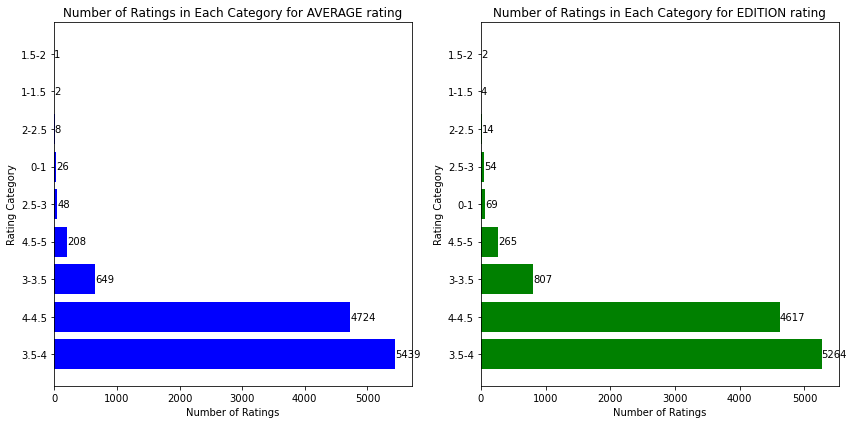

In [353]:
#We need to know if the repartition is the same for average rating or edition rating :

# Define bins and labels for average rating and edition rating
bins = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = ['0-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4', '4-4.5', '4.5-5']

# Create a new column with the bin labels for average rating and edition rating
df_rating['average_rating_category'] = pd.cut(df_rating['average_rating'], bins=bins, labels=labels, right=False)
df_rating['edition_rating_category'] = pd.cut(df_rating['edition_avgRating'], bins=bins, labels=labels, right=False)

# Count the number of ratings in each category for both
rating_counts_per_category_average = df_rating['average_rating_category'].value_counts()
rating_counts_per_category_edition = df_rating['edition_rating_category'].value_counts()

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first graph based on df_scraped['average_rating']
axs[0].barh(rating_counts_per_category_average.index, rating_counts_per_category_average.values, color='blue')
axs[0].set_title('Number of Ratings in Each Category for AVERAGE rating')
axs[0].set_xlabel('Number of Ratings')
axs[0].set_ylabel('Rating Category')

# Add values on top of each bar for the first graph
for index, value in enumerate(rating_counts_per_category_average):
    axs[0].text(value, index, str(value), ha='left', va='center')

# Plot the second graph based on df_scraped['edition_avgRating']
axs[1].barh(rating_counts_per_category_edition.index, rating_counts_per_category_edition.values, color='green')
axs[1].set_title('Number of Ratings in Each Category for EDITION rating')
axs[1].set_xlabel('Number of Ratings')
axs[1].set_ylabel('Rating Category')

# Add values on top of each bar for the second graph
for index, value in enumerate(rating_counts_per_category_edition):
    axs[1].text(value, index, str(value), ha='left', va='center')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

When we look at the ratings for each edition, there is a slight improvement in the data imbalance. There are more ratings below 3, which are categores with very few ratings.
But by calculating the mean of the difference for each line, we saw that the mean was 0.03. So for the vast majority of books, there is very few differences between the 2 ratings. 

In order to reduce the imbalalance we have for the ratings, and to add more relevance to the new data we scraped (like book format) and more coherence to already existent data (publication_date and number_of_pages both are link to the edition), we will now only look for the edition_avgRating column and delete the average_rating one.

### Add "size_of_publisher" column

In [354]:
# Adding the new columns that allows to see if a publisher is often cited
df_scraped['publisher_count'] = df_scraped.groupby('publisher')['publisher'].transform('count')

In [355]:
# The exact number of time a publisher name is in the database is not as relevant as the number of time an author or a title is
# in it.
# To simplify this information, we can, instead of the count, create a column that categorize the publisher :
# - Small publisher(1) = only 1 time in the database
# - Medium publisher(2) = from 2 to 10 times
# - big publisher(3) = more that 10 times

# Create a function to determine the size of the publisher based on the number of times it is mentioned
def determine_size(publisher_count):
    if publisher_count == 1:
        return 1
    elif publisher_count < 10:
        return 2
    else:
        return 3

# Apply the function to the 'publisher_count' column to create the new 'size_of_publisher' column
df_scraped['size_of_publisher'] = df_scraped['publisher_count'].apply(lambda x: determine_size(x))

In [356]:
print('Number of line with small publisher',len(df_scraped[df_scraped['size_of_publisher'] == 1]))
print('Number of line with medium publisher',len(df_scraped[df_scraped['size_of_publisher'] == 2]))
print('Number of line with big publisher',len(df_scraped[df_scraped['size_of_publisher'] == 3]))

Number of line with small publisher 1254
Number of line with medium publisher 2647
Number of line with big publisher 7226


In [357]:
#Now that we have the "size_of_publisher" column, let's delete the "publisher_count" used to create it 
df_scraped.drop(columns=['publisher_count'], inplace=True)

### Create "num_book_per_author" column

In [358]:
# Check for duplicates in a specific column using value_counts
num_book_per_author = df_scraped["first_author"].value_counts()

# Display values with count greater than 1 (indicating duplicates)
print(num_book_per_author[num_book_per_author > 1])

william shakespeare    88
stephen king           82
jrr tolkien            51
pg wodehouse           46
agatha christie        45
                       ..
paul farmer             2
amy sedaris             2
ruby ann boxcar         2
anthony loyd            2
james lee burke         2
Name: first_author, Length: 1471, dtype: int64


In [359]:
# Adding the new columns that allows to see if an author is often cited
df_scraped['num_book_per_author'] = df_scraped.groupby('first_author')['first_author'].transform('count')

In [360]:
df_scraped.sample(10)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,book_format,new_publisher,edition_avgRating,added_toShelves,added_toShelve,text_reviews_coun,first_author,num_contributors,size_of_publisher,num_book_per_author
4412,15872,harry potter y el misterio del príncipe harry ...,j.k. rowling/gemma rovira ortega,4.57,8478889930,9788478889938,spa,602,5104,386,...,hardcover,NaN,4.57,24223.0,NaN,NaN,jk rowling,2,2,24
857,2851,the invisible child,katherine paterson,4.27,0525464824,9780525464822,eng,266,99,27,...,hardcover,dutton children's books,4.25,612.0,NaN,NaN,katherine paterson,1,2,3
8362,32144,the mammoth book of egyptian whodunnits,mike ashley/elizabeth peters/lynda s. robinson...,3.91,0786710659,9780786710652,eng,512,161,9,...,paperback,running press,3.88,811.0,NaN,NaN,mike ashley,4,3,2
7573,29083,snow,roy mckie/p.d. eastman,4.15,0394800273,9780394800271,eng,72,4383,88,...,hardcover,random house,4.16,7101.0,NaN,NaN,roy mckie,2,3,1
3784,13608,ヒカルの碁 9本戦開始,yumi hotta/yumi hotta,4.27,4088730224,9784088730226,jpn,207,9,2,...,コミック,NaN,3.92,23.0,NaN,NaN,yumi hotta,2,3,16
63,99,the players handbook the ultimate guide on dat...,heidi fleiss/libby keatinge,3.82,0972016414,9780972016414,eng,123,34,8,...,paperback,one hour entertainment,3.69,241.0,NaN,NaN,heidi fleiss,2,1,1
3956,14055,the little friend,donna tartt,3.46,0747562113,9780747562115,eng,559,220,25,...,hardcover,NaN,3.36,553.0,NaN,NaN,donna tartt,1,3,3
10674,43490,runaways orphans 5,v.c. andrews,3.77,0671007637,9780671007638,eng,342,5121,78,...,paperback,pocket books,3.79,11214.0,NaN,NaN,vc andrews,1,3,19
4563,16401,the luck of the bodkins,p.g. wodehouse,4.08,1585673366,9781585673360,eng,358,1290,88,...,hardcover,the overlook press,4.07,4225.0,NaN,NaN,pg wodehouse,1,3,46
8641,33288,how to win friends and influence people,dale carnegie,4.19,0091906814,9780091906818,eng,268,1842,104,...,paperback,NaN,4.14,5275.0,NaN,NaN,dale carnegie,1,2,8


### Create "is_english" column

In [361]:
# Add a new column 'is_english' with 1 for English (en, en-CA, en-GB,...) and 0 for non-English
df_scraped['is_english'] = np.where(df_scraped['language_code'].str.contains('en', case=False), 1, 0)

In [362]:
df_scraped.sample(10)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,new_publisher,edition_avgRating,added_toShelves,added_toShelve,text_reviews_coun,first_author,num_contributors,size_of_publisher,num_book_per_author,is_english
3090,11373,main street,sinclair lewis/brooke allen,3.77,1593080360,9781593080365,en-us,560,286,37,...,NaN,3.51,716.0,NaN,NaN,sinclair lewis,2,3,8,1
10735,43781,merrick the vampire chronicles 7,anne rice,3.73,0345422406,9780345422408,eng,370,35529,478,...,ballantine books,3.76,74706.0,NaN,NaN,anne rice,1,3,23,1
7701,29625,the origin of consciousness in the breakdown o...,julian jaynes,4.25,0713912545,9780713912548,en-gb,467,7,1,...,NaN,3.89,14.0,NaN,NaN,julian jaynes,1,2,2,1
10078,40597,my dirty thirties romantic hedonism,kelly carr,3.00,1932420347,9781932420340,eng,144,8,1,...,new traditions books,2.57,19.0,NaN,NaN,kelly carr,1,1,1,1
4980,18013,the pirate dictionary,terry breverton,3.70,1589802438,9781589802438,eng,189,51,7,...,pelican publishing,3.80,245.0,NaN,NaN,terry breverton,1,1,1,1
1247,4315,zaat,sonallah ibrahim/صنع الله إبراهيم/anthony cald...,3.55,9774248449,9789774248443,ara,349,122,12,...,NaN,3.81,597.0,NaN,NaN,sonallah ibrahim,3,1,1,0
7217,27674,on christian belief works of saint augustine,augustine of hippo/boniface ramsey/michael fie...,4.08,1565482344,9781565482340,eng,372,12,1,...,new city press,4.15,46.0,NaN,NaN,augustine of hippo,3,2,13,1
10193,41278,kick the can oneeyed mack 1,jim lehrer,3.85,1571780599,9781571780591,eng,223,77,10,...,council oak books,3.79,195.0,NaN,NaN,jim lehrer,1,1,5,1
6324,23835,cognitive behavioral treatment of insomnia a s...,michael l. perlis/carla jungquist/michael t. s...,4.05,0387222529,9780387222523,eng,182,2,1,...,NaN,3.50,8.0,NaN,NaN,michael l perlis,3,2,1,1
9380,37187,the tiger rising,kate dicamillo,3.82,0763618985,9780763618988,eng,128,19133,2279,...,candlewick press,3.83,44653.0,NaN,NaN,kate dicamillo,1,3,7,1


### Create "book_count" column

In [363]:
# Adding the new columns that allows to see if a book is often cited
df_scraped['book_count'] = df_scraped.groupby('title')['title'].transform('count')

In [364]:
df_scraped.query("title == 'the brothers karamazov'")

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,edition_avgRating,added_toShelves,added_toShelve,text_reviews_coun,first_author,num_contributors,size_of_publisher,num_book_per_author,is_english,book_count
1406,4933,the brothers karamazov,fyodor dostoyevsky/constance garnett/manuel ko...,4.32,0451527348,9780451527349,eng,736,983,91,...,4.27,1638.0,NaN,NaN,fyodor dostoyevsky,4,3,37,1,9
1407,4934,the brothers karamazov,fyodor dostoyevsky/fyodor dostoevsky/richard p...,4.32,0374528373,9780374528379,eng,796,191531,6795,...,4.35,855582.0,NaN,NaN,fyodor dostoyevsky,4,3,37,1,9
1408,4935,the brothers karamazov,fyodor dostoyevsky/david mcduff,4.32,0140449248,9780140449242,eng,1013,1673,184,...,4.44,11774.0,NaN,NaN,fyodor dostoyevsky,2,3,37,1,9
1409,4936,the brothers karamazov,fyodor dostoyevsky/richard pevear/larissa volo...,4.32,0679729259,9780679729259,eng,796,617,80,...,4.51,1381.0,NaN,NaN,fyodor dostoyevsky,3,3,37,1,9
1410,4938,the brothers karamazov,fyodor dostoyevsky/simon vance/thomas r. beyer...,4.32,1596440791,9781596440791,eng,16,20,2,...,4.52,164.0,NaN,NaN,fyodor dostoyevsky,3,2,37,1,9
1411,4940,the brothers karamazov,fyodor dostoyevsky/constance garnett/maire jaanus,4.32,159308045x,9781593080457,eng,720,1089,202,...,4.38,3421.0,NaN,NaN,fyodor dostoyevsky,3,3,37,1,9
1634,5691,the brothers karamazov,fyodor dostoyevsky/richard pevear/larissa volo...,4.32,0099922800,9780099922803,eng,796,443,55,...,4.45,1657.0,NaN,NaN,fyodor dostoyevsky,3,3,37,1,9
1990,7135,the brothers karamazov,fyodor dostoyevsky/andrew r. macandrew/konstan...,4.32,0553212168,9780553212167,eng,1072,1022,154,...,4.37,3236.0,NaN,NaN,fyodor dostoyevsky,3,3,37,1,9
9356,37058,the brothers karamazov,fyodor dostoyevsky/thomas r. beyer jr./simon v...,4.32,1596440783,9781596440784,eng,16,3,1,...,4.67,9.0,NaN,NaN,fyodor dostoyevsky,3,2,37,1,9


### Create a "is_serie" column

In [365]:
# Create a regular expression pattern to match titles containing numbers
pattern = r'\b\d{1,2}\b'  # This pattern matches 1 or 2 digits, if a number has more that 2 digits it's not a number of books in a serie

# Use the str.contains() method with the regex pattern to filter the DataFrame
books_with_number = df_scraped[df_scraped['title'].str.contains(pattern)]

# Print or further process the extracted books
books_with_number['title'].sample(20)

9618                            the ring volume 4 birthday
9402                       certain prey lucas davenport 10
6716        the man with a load of mischief richard jury 1
10095                              blowback scot harvath 4
7660                                 demon diary volume 04
10474                 nimitz class admiral arnold morgan 1
3755                                    vagabond volume 20
3807                 hana yori dango 3 boys over flowers 3
5556                     hunters of dune dune chronicles 7
5461                   wild card tom clancys power plays 8
7317     ghosthunters and the incredibly revolting ghos...
1883                going solo roald dahls autobiography 2
5762                                     chance spenser 23
5609     literary criticism vol 1 essays on literature ...
5583                the spiral stair arabel and mortimer 6
6075                                                犬夜叉 26
898      the adventures of huckleberry finn adventures .

In [366]:
# Add a new column 'is_serie' with 1 for books with a number in the title and 0 for books without numbers
df_scraped['is_serie'] = np.where(df_scraped['title'].str.contains(pattern), 1, 0)

In [367]:
df_scraped.sample(10)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,added_toShelves,added_toShelve,text_reviews_coun,first_author,num_contributors,size_of_publisher,num_book_per_author,is_english,book_count,is_serie
6706,25150,pledged the secret life of sororities,alexandra robbins,3.18,1401300464,9781401300463,en-us,384,245,30,...,443.0,NaN,NaN,alexandra robbins,1,2,1,1,1,0
2256,8084,beauty,robin mckinley,4.05,0060753102,9780060753108,eng,325,3258,478,...,5724.0,NaN,NaN,robin mckinley,1,3,13,1,2,0
8930,34541,carpe jugulum discworld 23 witches 6,terry pratchett,4.14,0061051586,9780061051586,eng,296,41899,746,...,80774.0,NaN,NaN,terry pratchett,1,3,31,1,1,1
9127,35499,side effects,amy goldman koss,3.87,1596432942,9781596432949,eng,144,904,179,...,1742.0,NaN,NaN,amy goldman koss,1,2,1,1,1,0
6321,23824,speaks the nightbird matthew corbett 1,robert r. mccammon,4.13,1880216620,9781880216620,en-us,726,145,31,...,326.0,NaN,NaN,robert r mccammon,1,1,10,1,1,1
9757,39022,saint ignatius loyola the pilgrim years 14911538,james brodrick,4.09,0898706831,9780898706833,eng,350,11,1,...,67.0,NaN,NaN,james brodrick,1,2,1,1,1,0
1494,5191,the pilots wife,anita shreve,3.52,0316601950,9780316601955,eng,304,78714,3860,...,132714.0,NaN,NaN,anita shreve,1,3,5,1,1,0
9493,37684,the lion the witch and the wardrobe chronicles...,hiawyn oram/c.s. lewis/tudor humphries,4.25,0060556501,9780060556501,eng,48,6307,64,...,25233.0,NaN,NaN,hiawyn oram,3,3,1,1,1,1
3740,13530,foreign correspondence a pen pals journey from...,geraldine brooks,3.85,0385483732,9780385483735,eng,240,1428,204,...,5159.0,NaN,NaN,geraldine brooks,1,3,3,1,1,0
122,247,quiet days in clichy,henry miller,3.69,080213016x,9780802130167,eng,154,3381,141,...,7597.0,NaN,NaN,henry miller,1,3,8,1,1,0


In [368]:
#Let's see if we have to add some books in "is_serie" based on word in there title
df_scraped[(df_scraped['is_serie'] == '0') & (df_scraped['title'].str.contains('trilogy|tome|chronicles|series', case=False))]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,added_toShelves,added_toShelve,text_reviews_coun,first_author,num_contributors,size_of_publisher,num_book_per_author,is_english,book_count,is_serie


### Convert the first_published date into 2 columns : published_year, published_month

By looking at the data, we notice that for some line, the first_published date didn't extracted well, and it's written "ary" instead of january or february.

In [369]:
df_scraped[['title','first_published']][df_scraped['first_published'].str.contains(r'ary', case=False) & ~df_scraped['first_published'].str.contains(r'january|february', case=False)]

,title,first_published
56,simply beautiful beaded jewelry,"ary 28, 2006"
77,the power of one the solo play for playwrights...,"ary 7, 2000"
124,tropic of capricorn,"ary 1, 1939"
176,gravitys rainbow,"ary 28, 1973"
179,gravitys rainbow,"ary 28, 1973"
...,...,...
11067,the home front,"ary 23, 1989"
11090,la conspiración de los alquimistas,"ary 1, 1999"
11092,the call of the mall how we shop,"ary 2, 2004"
11101,undaunted courage the pioneering first mission...,"ary 15, 1996"


In [370]:
#We will replace the "ary" in those line by "february" 
# Filter rows containing "ary" but not "january" or "february"
filtered_rows = df_scraped['first_published'].str.contains(r'ary', case=False) & ~df_scraped['first_published'].str.contains(r'january|february', case=False)

# Replace the filtered results with "february"
df_scraped.loc[filtered_rows, 'first_published'] = df_scraped.loc[filtered_rows, 'first_published'].str.replace(r'ary', 'february', case=False)

In [371]:
df_scraped[['title','first_published']][df_scraped['first_published'].str.contains('published', case=False)]

,title,first_published
133,love letters,"published january 1, 1999"
201,timbuktu leviathan moon palace,"published october 31, 2002"
203,the coming economic collapse how you can thriv...,"published february 21, 2006"
229,guidebook to zen and the art of motorcycle mai...,"published november 19, 1990"
263,best of london lonely planet best of,"published january 1, 2004"
...,...,...
10881,the best american travel writing 2006,"published october 11, 2006"
10898,poems between women four centuries of love rom...,"published april 15, 1999"
10937,un amour de swann à la recherche du temps perd...,"published january 1, 2006"
10947,poetry and prose of alexander pope riverside e...,"published january 2, 1968"


In [372]:
#Let's delete the word "published" from the first_published column
df_scraped['first_published'] = df_scraped['first_published'].str.replace('published ', '')

By trying to convert the "first_published" column into date, we notice several errors due to date before 1677. Indeed, the smallest date that pandas can handle is January 1, 1677. As we are looking for an average rating given on a website, there is probably not a big difference between books written in 1524 or 1678, as they are considered "old". By lack of time, we'll change all year below 1677 by 1678.

In [373]:
# The smallest date that pandas can handle is January 1, 1677. Let's remove all date below 1677 and change the year by 1678
for i, date_str in enumerate(df_scraped['first_published']):
    # Use regular expression to find the year in the string
    match = re.search(r'\b\d{1,4}\b$', date_str)
    if match:
        year = int(match.group())
        if year < 1677:
            # Replace the year with 1678
            modified_date_str = re.sub(r'\b\d{1,4}\b$', '1678', date_str)
            df_scraped.at[i, 'first_published'] = modified_date_str

In [374]:
df_scraped['first_published'] = pd.to_datetime(df_scraped['first_published'], format='%B %d, %Y')

In [375]:
# Convert the first_published date into 3 columns : published_year, published_month, published_day
df_scraped['published_year'] = df_scraped['first_published'].dt.year
df_scraped['published_month'] = df_scraped['first_published'].dt.month


In [376]:
df_scraped.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,text_reviews_coun,first_author,num_contributors,size_of_publisher,num_book_per_author,is_english,book_count,is_serie,published_year,published_month
6501,24521,the hundred days aubrey maturin 19,patrick o'brian,4.35,0393319792,9780393319798,eng,281,5325,150,...,NaN,patrick obrian,1,3,14,1,1,1,1998,1
7048,26829,canadas incredible coasts,donald j. crump/william r. gray,3.71,0870448293,9780870448294,eng,199,7,0,...,NaN,donald j crump,2,2,1,1,1,0,1993,1
1376,4812,the quest for longitude the proceedings of the...,william andrewes,4.50,0964432900,9780964432901,eng,437,10,2,...,NaN,william andrewes,1,1,1,1,1,1,1996,11
1688,5883,the pirate chase pirates of the caribbean jack...,rob kidd/walt disney company,3.89,1423100204,9781423100201,eng,119,730,20,...,NaN,rob kidd,2,3,5,1,1,1,2006,8
2928,10863,pipe dream strivers row,solomon jones,3.97,0375756604,9780375756603,eng,341,139,17,...,NaN,solomon jones,1,2,1,1,1,0,2001,1


### Convert the publication_date into 2 columns : edition_year, edition_month

Our target is now the rating for each edition, so the date of publication of each edition is important (if it's different from the first published date)

In [377]:
df_scraped['publication_date'] = pd.to_datetime(df_scraped['publication_date'])
# Convert the first_published date into 3 columns : published_year, published_month, published_day
df_scraped['edition_year'] = df_scraped['first_published'].dt.year
df_scraped['edition_month'] = df_scraped['first_published'].dt.month

In [378]:
df_scraped.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,num_contributors,size_of_publisher,num_book_per_author,is_english,book_count,is_serie,published_year,published_month,edition_year,edition_month
6629,24920,the discomfort zone a personal history,jonathan franzen,3.40,0374299196,9780374299194,eng,195,4760,532,...,1,3,7,1,1,0,2006,1,2006,1
4749,17054,stardust of yesterday de piaget 9 de paigetmac...,lynn kurland,4.09,042518238x,9780425182383,eng,368,3709,169,...,1,3,1,1,1,1,1996,4,1996,4
8350,32111,the foundling,georgette heyer/kay hooper,3.87,0373835493,9780373835492,eng,406,3716,270,...,2,2,10,1,1,0,1948,1,1948,1
9896,39823,murder unleashed jack and jamie 2,lee charles kelley,3.95,0060524944,9780060524944,eng,304,61,10,...,1,3,4,1,1,1,2004,1,2004,1
2598,9550,in praise of shadows,jun'ichirō tanizaki/thomas j. harper/edward g....,4.09,0099283573,9780099283577,eng,73,467,32,...,3,3,9,1,2,0,1933,1,1933,1


### Categorization then encoding of Book_format

In [379]:
df_scraped['book_format'].unique()

array(['paperback', 'hardcover', 'mass market paperback', 'leather bound',
       'audio cd', 'library binding', 'paper', 'product bundle',
       'perfect paperback', 'imitation leather', 'hardback', 'cloth',
       'mp3 cd', 'softcover', 'ebook', 'board book', 'unknown binding',
       'textbook binding', 'pocket book', 'audiobook', 'audio cassette',
       '240 pages', 'taschenbuch', 'wireless phone accessory',
       "publisher's binding", 'cd-rom', 'audio', 'コミック',
       'trade paperback', 'unbound', 'spiral-bound',
       'school & library binding', 'diary', 'kindle edition', 'comic',
       'slipcased hardcover', 'poche', 'unknown', 'dvd and book',
       'flexibound', '156 pages', 'comics', 'paperback manga',
       'staple bound', 'bath book', 'capa mole'], dtype=object)

In [380]:
#There seems to be mistakes for some lines, with "book format" = "xx pages", let's look at one of those lines
df_scraped.loc[df_scraped['book_format'] == '156 pages'].transpose()

,7724
bookID,29776
title,the dying animal
authors,philip roth
average_rating,3.63
isbn,0099422697
isbn13,9780099422693
language_code,eng
num_pages,156
ratings_count,5910
text_reviews_count,437


In [381]:
#Let's create a new columns to translate those multiples book_format into less category :
# First we define the categories
categories = {
    'hardcover': ['hardcover', 'leather bound', 'library binding', 'hardback', "publisher's binding", 'slipcased hardcover','board book','textbook binding'],
    'paperback': ['paperback', 'mass market paperback', 'perfect paperback', 'softcover', 'trade paperback', 'paperback manga', 'taschenbuch','poche','flexibound', 'capa mole','pocket book'],
    'audio': ['audio cd', 'mp3 cd', 'audiobook', 'audio cassette', 'cd-rom','audio'],
    'ebook': ['ebook', 'kindle edition'],
    'books': ['paper','unbound', 'spiral-bound','240 pages','school & library binding','156 pages','staple bound','diary','imitation leather'],
    'comics': ['コミック','comic','comics'],
    'other': ['unknown binding', 'unknown', 'product bundle', 'cloth', 'wireless phone accessory', 'dvd and book', 'bath book']
}

# Function to map the value of book_format to the corresponding category
def map_category(format):
    for category, formats in categories.items():
        if format in formats:
            return category
    return None

# Create a new column "category" by applying the map_category function to the "book_format" column
df_scraped['category'] = df_scraped['book_format'].apply(map_category)

In [382]:
df_scraped[['book_format','category']].sample(5)

,book_format,category
8951,paperback,paperback
8704,paperback,paperback
9663,hardcover,hardcover
3192,paperback,paperback
4973,paperback,paperback


In [383]:
df_scraped['category'].isnull().any()

False

In [384]:
#Let's create the function to do the one-hot encoding 
def one_hot_encode(df, column_name):
    encoded_columns = pd.get_dummies(df[column_name], prefix=column_name)
    
    # Concatenate the encoded columns to the original DataFrame
    df = pd.concat([df, encoded_columns], axis=1)
    
    # Drop the original column
    df.drop(column_name, axis=1, inplace=True)
    
    return df

In [385]:
#We will do this encoding on the category column 
df_scraped = one_hot_encode(df_scraped, 'category')

In [386]:
df_scraped.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,published_month,edition_year,edition_month,category_audio,category_books,category_comics,category_ebook,category_hardcover,category_other,category_paperback
5267,19043,tabby in the tub animal ark 29,ben m. baglio/linda chapman/jenny gregory,3.96,0439343909,9780439343909,eng,139,768,33,...,11,1999,11,0,0,0,0,0,0,1
6672,25037,el rey de les halles,juliette benzoni/francisco rodriguez de lecea,4.19,8466619453,9788466619455,spa,448,207,5,...,1,1998,1,0,0,0,0,0,0,1
10238,41491,silent night the remarkable christmas truce of...,stanley weintraub,3.60,0684866226,9780684866222,eng,256,4041,179,...,1,2001,1,0,0,0,0,0,0,1
263,793,best of london lonely planet best of,lonely planet/sarah johnstone/steve fallon,3.83,1740594770,9781740594776,eng,128,11,0,...,1,2004,1,0,0,0,0,0,0,1
9719,38775,autobiography of thomas jefferson,thomas jefferson,3.89,0486442896,9780486442891,eng,112,696,34,...,1,1821,1,0,0,0,0,0,0,1


### Removal of text columns and unnecessary columns

In [387]:
df_forML = df_scraped.copy()

# List of columns to remove
columns_to_remove = ['title', 'authors', 'isbn', 'language_code', 'publication_date', 'publisher', 
                     'first_published', 'book_format', 'new_publisher', 'added_toShelve', 
                     'text_reviews_coun', 'first_author','average_rating']

# Remove the specified columns from df_forML
df_forML.drop(columns=columns_to_remove, inplace=True)

In [388]:
df_forML.sample(3).transpose()

,10923,1699,7646
bookID,4.473500e+04,5.911000e+03,2.946000e+04
isbn13,9.780882e+12,9.780618e+12,9.780495e+12
num_pages,3.520000e+02,5.700000e+01,7.420000e+02
ratings_count,7.564000e+03,1.690000e+02,1.000000e+00
text_reviews_count,2.060000e+02,5.000000e+00,0.000000e+00
edition_avgRating,4.230000e+00,4.330000e+00,5.000000e+00
added_toShelves,1.791100e+04,1.090000e+03,7.000000e+00
num_contributors,1.000000e+00,1.000000e+00,1.000000e+00
size_of_publisher,1.000000e+00,3.000000e+00,2.000000e+00
num_book_per_author,1.000000e+00,5.100000e+01,1.000000e+00


In [307]:
#We can now save this dataframe in a csv file in order to use it in the notebook for Machine Learning
df_forML.to_csv("dataframe_forML.csv", index_label=False)